In [1]:
import pickle
import numpy as np
import pandas as pd

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9640\1985236167.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

In [4]:
import optuna
import lightgbm as lgb

c:\Users\Aaron\Desktop\Projects\kaggle-binary_classification_bank_churn\scripts\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [6]:
SEED_NUM = 12

In [39]:
# Use both the given training data and the original bank churn dataset as training
# More data is better, might help with generalisation too
df_train = pd.concat([pd.read_csv("../data/train.csv"), pd.read_csv("../data/Churn_Modelling.csv")]).reset_index(drop=True)
df_test = pd.read_csv("../data/test.csv")
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175036 entries, 0 to 175035
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  float64
 1   CustomerId       175036 non-null  int64  
 2   Surname          175036 non-null  object 
 3   CreditScore      175036 non-null  int64  
 4   Geography        175035 non-null  object 
 5   Gender           175036 non-null  object 
 6   Age              175035 non-null  float64
 7   Tenure           175036 non-null  int64  
 8   Balance          175036 non-null  float64
 9   NumOfProducts    175036 non-null  int64  
 10  HasCrCard        175035 non-null  float64
 11  IsActiveMember   175035 non-null  float64
 12  EstimatedSalary  175036 non-null  float64
 13  Exited           175036 non-null  int64  
 14  RowNumber        10002 non-null   float64
dtypes: float64(7), int64(5), object(3)
memory usage: 20.0+ MB
None


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,RowNumber
0,0.0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,NaN
1,1.0,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,NaN
2,2.0,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,NaN
3,3.0,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,NaN
4,4.0,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,NaN


In [40]:
# Drop columns that are not useful
# id, CustomerId and RowNumber
df_train = df_train.drop(columns=["id", "CustomerId", "RowNumber"])
df_test = df_test.drop(columns=["id", "CustomerId"])

-0.06594209001754278
-0.07585672881753114


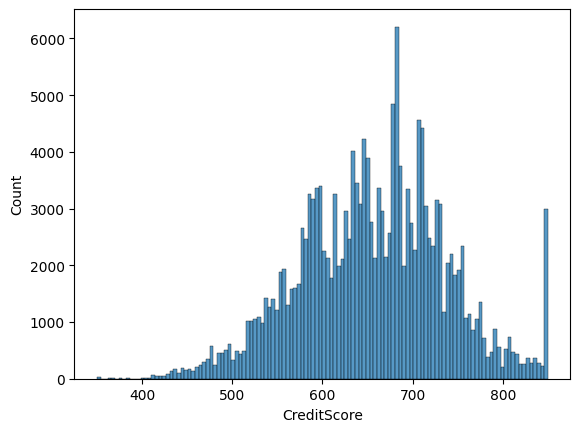

In [9]:
# Credit score
sns.histplot(df_train, x="CreditScore")
print(df_train["CreditScore"].skew())
print(df_train["CreditScore"].kurtosis())

In [10]:
# Geography
# To impute with most frequent
simpute_geog = SimpleImputer(strategy="most_frequent")
print(df_train["Geography"].isna().sum())
print(df_train["Geography"].value_counts())
df_train[["Geography"]] = simpute_geog.fit_transform(df_train[["Geography"]])
print(df_train["Geography"].isna().sum())
ord_geog = OrdinalEncoder()
df_train["Geography"] = ord_geog.fit_transform(df_train[["Geography"]])

1
Geography
France     99229
Spain      38690
Germany    37116
Name: count, dtype: int64
0


In [11]:
# Surname
# Target encode
print(df_train["Surname"].isna().sum())
df_train["Surname"].value_counts()
tencode_surname = TargetEncoder(target_type="binary", random_state=SEED_NUM)
df_train[["Surname"]] = tencode_surname.fit_transform(df_train[["Surname"]], df_train["Exited"])

0


In [12]:
# Gender
# One hot this later, drop first
ord_gender = OrdinalEncoder()
print(df_train["Gender"].value_counts())
print(df_train["Gender"].isna().sum())
df_train["Gender"] = ord_gender.fit_transform(df_train[["Gender"]])

Gender
Male      98608
Female    76428
Name: count, dtype: int64
0


In [13]:
# Age
# Impute one missing value with the mean
# Log age
print(df_train["Age"].isna().sum())
print(df_train["Age"].kurtosis())
print(df_train["Age"].skew())
simpute_age = SimpleImputer(strategy="mean")
df_train["Age"] = simpute_age.fit_transform(df_train[["Age"]])
print(np.log(df_train["Age"]).skew())
df_train["Age"] = np.log(df_train["Age"])
print(df_train["Age"].isna().sum())

1
1.5673392061977527
0.9798224944704611
0.1874492024532843
0


In [14]:
cat_cols = ["Gender", "IsActiveMember", "HasCrCard", "Geography"]
df_train.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.335637,668,0.0,1.0,3.496508,3,0.00,2,1.0,0.0,181449.97,0
1,0.329926,627,0.0,1.0,3.496508,1,0.00,2,1.0,1.0,49503.50,0
2,0.223065,678,0.0,1.0,3.688879,10,0.00,2,1.0,0.0,184866.69,0
3,0.185433,581,0.0,1.0,3.526361,2,148882.54,1,1.0,1.0,84560.88,0
4,0.162756,716,2.0,1.0,3.496508,5,0.00,2,1.0,1.0,15068.83,0


In [15]:
# Train test split
x_train, x_valid, y_train, y_valid = train_test_split(df_train.drop(columns="Exited"),
                                                      df_train["Exited"], train_size=0.8,
                                                      shuffle=True, random_state=SEED_NUM)

In [16]:
# Objective for lightGBM and optuna tuning
def objective(trial, x_train, y_train):

    # Hyperparameter search space
    params = {"objective": "binary",
              "boostin_type": "gbdt",
              "metric": "auc",
              "verbosity": -1,
              "num_iterations": trial.suggest_int("num_iterations", 20, 1000),
              "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10, log=True),
              "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10, log=True),
              "max_depth": trial.suggest_int("max_depth", 2, 15),
              "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 1.0),
              "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 1.0),
              "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
              "min_data_in_leaf": trial.suggest_int("min_child_samples", 5, 100),
              "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)}
    params["num_leaves"] = trial.suggest_int("num_leaves", max(2, 2 ** int(params["max_depth"] * 0.3)), 2 ** int(params["max_depth"] * 0.8))

    # Cross validation
    list_cv_errors = []
    kfold = KFold(n_splits=10, random_state=SEED_NUM, shuffle=True)
    for idx_train, idx_valid in kfold.split(x_train, y_train):
        data_train = lgb.Dataset(x_train.iloc[idx_train],
                                 y_train.iloc[idx_train],
                                 categorical_feature=cat_cols)
        temp_valid_x = x_train.iloc[idx_valid]
        temp_valid_y = y_train.iloc[idx_valid]
        temp_model = lgb.train(params,
                               data_train,
                               categorical_feature=cat_cols,
                               valid_sets=data_train)
        temp_error = roc_auc_score(temp_valid_y, temp_model.predict(temp_valid_x))
        list_cv_errors.append(temp_error)

    return np.mean(list_cv_errors)

In [17]:
# Create optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(n_startup_trials=200))
study.optimize(lambda trial: objective(trial, x_train, y_train),
               n_jobs=-1, n_trials=1000)

[I 2024-01-28 11:47:32,977] A new study created in memory with name: no-name-4bd61759-f6bb-42b6-96f3-f60f03b099ef
[I 2024-01-28 11:47:41,437] Trial 0 finished with value: 0.8750741830590437 and parameters: {'num_iterations': 61, 'lambda_l1': 2.187299129007842e-05, 'lambda_l2': 4.237160695146376, 'max_depth': 5, 'feature_fraction': 0.8985358560317351, 'bagging_fraction': 0.5749240454310904, 'bagging_freq': 10, 'min_child_samples': 74, 'learning_rate': 0.028617672699297825, 'num_leaves': 6}. Best is trial 0 with value: 0.8750741830590437.
[I 2024-01-28 11:50:13,977] Trial 6 finished with value: 0.8923627967686343 and parameters: {'num_iterations': 803, 'lambda_l1': 1.1477897267257884e-08, 'lambda_l2': 3.9877151906879376e-07, 'max_depth': 5, 'feature_fraction': 0.4717623985551978, 'bagging_fraction': 0.4338754248321849, 'bagging_freq': 9, 'min_child_samples': 84, 'learning_rate': 0.047945061377076215, 'num_leaves': 11}. Best is trial 6 with value: 0.8923627967686343.
[I 2024-01-28 11:50:2

KeyboardInterrupt: 

[I 2024-01-28 18:49:33,399] Trial 405 finished with value: 0.892625220057367 and parameters: {'num_iterations': 979, 'lambda_l1': 4.068194621548189e-08, 'lambda_l2': 0.00017261259059151758, 'max_depth': 11, 'feature_fraction': 0.7157969524628575, 'bagging_fraction': 0.8390024823978244, 'bagging_freq': 8, 'min_child_samples': 99, 'learning_rate': 0.03738318675243856, 'num_leaves': 12}. Best is trial 292 with value: 0.8927009092177712.


In [18]:
print(study.best_params)
with open("../results/best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

{'num_iterations': 962, 'lambda_l1': 3.2524251402302055e-08, 'lambda_l2': 0.0002796651925180598, 'max_depth': 12, 'feature_fraction': 0.819572918297371, 'bagging_fraction': 0.733303956808943, 'bagging_freq': 8, 'min_child_samples': 98, 'learning_rate': 0.019026473079532324, 'num_leaves': 24}


In [20]:
# Read best params
with open("../results/best_params.pkl", "rb") as f:
    best_params = pickle.load(f)
best_params

{'num_iterations': 962,
 'lambda_l1': 3.2524251402302055e-08,
 'lambda_l2': 0.0002796651925180598,
 'max_depth': 12,
 'feature_fraction': 0.819572918297371,
 'bagging_fraction': 0.733303956808943,
 'bagging_freq': 8,
 'min_child_samples': 98,
 'learning_rate': 0.019026473079532324,
 'num_leaves': 24}

In [26]:
# Run final model
train_data = lgb.Dataset(df_train.drop(columns="Exited"),
                         df_train["Exited"],
                         categorical_feature=cat_cols)
model = lgb.train(best_params,
                  train_data,
                  valid_sets=train_data,
                  categorical_feature=cat_cols)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 175036, number of used features: 11
[LightGBM] [Info] Start training from score 0.211151


In [41]:
# Preprocess test set
df_test["Geography"] = ord_geog.transform(df_test[["Geography"]])
df_test["Surname"] = tencode_surname.transform(df_test[["Surname"]])
df_test["Gender"] = ord_gender.transform(df_test[["Gender"]])
df_test["Age"] = np.log(df_test["Age"])

In [47]:
# Create submission
sample = pd.read_csv("../data/sample_submission.csv")
results = sample.copy()
results["Exited"] = model.predict(df_test)
results

,id,Exited
0,165034,0.031078
1,165035,0.829702
2,165036,0.020753
3,165037,0.227813
4,165038,0.362980
...,...,...
110018,275052,0.022795
110019,275053,0.170705
110020,275054,0.016855
110021,275055,0.203729


In [48]:
# Output as csv
results.to_csv("../results/submission.csv", index=False)